# Pytorch Baseline Model - FasterRCNN


- FasterRCNN from torchvision
- Use Resnet50 backbone
- Albumentation enabled (simple flip for now)


In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [3]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


#### small test for cv2 library

In [4]:
train_picture1 = cv2.imread(f'{DIR_INPUT}/train/b6ab77fd7.jpg', cv2.IMREAD_COLOR)

In [5]:
cv2.cvtColor(train_picture1, cv2.COLOR_BGR2RGB).astype(np.float32)

array([[[ 26.,  24.,  25.],
        [ 30.,  28.,  29.],
        [ 36.,  34.,  35.],
        ...,
        [ 72.,  97.,  68.],
        [ 74.,  97.,  69.],
        [ 74.,  97.,  68.]],

       [[ 24.,  22.,  23.],
        [ 27.,  25.,  26.],
        [ 33.,  31.,  32.],
        ...,
        [ 68.,  92.,  66.],
        [ 68.,  93.,  64.],
        [ 68.,  93.,  64.]],

       [[ 21.,  19.,  20.],
        [ 24.,  22.,  23.],
        [ 29.,  27.,  28.],
        ...,
        [ 65.,  91.,  66.],
        [ 65.,  91.,  66.],
        [ 65.,  91.,  66.]],

       ...,

       [[ 56.,  56.,  56.],
        [ 56.,  56.,  56.],
        [ 56.,  56.,  56.],
        ...,
        [221., 208., 156.],
        [224., 212., 162.],
        [221., 211., 160.]],

       [[ 60.,  60.,  60.],
        [ 59.,  59.,  59.],
        [ 58.,  58.,  58.],
        ...,
        [201., 188., 135.],
        [206., 194., 142.],
        [209., 199., 146.]],

       [[ 63.,  63.,  63.],
        [ 62.,  62.,  62.],
        [ 61.,  

In [6]:
train_picture1.shape

(1024, 1024, 3)

In [7]:
train_df

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


In [8]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

### Select some train example as validation set

There are 3000 training pictures, we select 20% as validation

In [9]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-600:]
train_ids = image_ids[:-600]

In [10]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [11]:
valid_df.shape, train_df.shape

((22688, 8), (125105, 8))

When the image file is read with the OpenCV function imread(), the order of colors is BGR (blue, green, red). On the other hand, in Pillow, the order of colors is assumed to be RGB (red, green, blue).

Therefore, if we want to use both the Pillow function and the OpenCV function, you need to convert BGR and RGB.

The only specificity that we require is that the dataset __getitem__ should return:

* image: a PIL Image of size (H, W)

* target: a dict containing the following fields
* boxes (FloatTensor[N, 4]): the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
* labels (Int64Tensor[N]): the label for each bounding box. 0 represents always the background class.
* image_id (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
* area (Tensor[N]): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
* iscrowd (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation.

One note on the labels. The model considers class 0 as background. 

If your dataset does not contain the background class, we should not have 0 in your labels. 

For example, assuming we have just two classes, cat and dog, we can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has booth classes, our labels tensor should look like [1,2].

In [12]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [13]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Create the model

In [14]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [15]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Sample

In [19]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [20]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

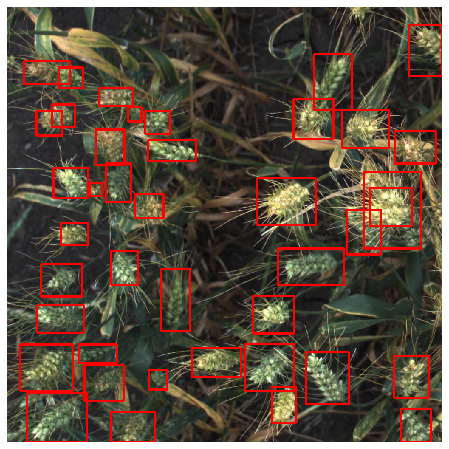

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Train

In [22]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = None

num_epochs = 3

In [23]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #50 loss: 0.7863344550132751
Iteration #100 loss: 0.7747039794921875
Iteration #150 loss: 0.7402229309082031
Iteration #200 loss: 0.5891534090042114
Iteration #250 loss: 0.6136330962181091
Iteration #300 loss: 0.5574276447296143
Epoch #0 loss: 0.7614984634286732
Iteration #350 loss: 0.6864355802536011
Iteration #400 loss: 0.6504767537117004
Iteration #450 loss: 0.8095116019248962
Iteration #500 loss: 0.6863483190536499
Iteration #550 loss: 0.5583466291427612
Iteration #600 loss: 0.475592702627182
Iteration #650 loss: 0.6669568419456482
Epoch #1 loss: 0.6653508911558805
Iteration #700 loss: 0.6140632033348083
Iteration #750 loss: 0.6636146903038025
Iteration #800 loss: 0.6989919543266296
Iteration #850 loss: 0.6858159303665161
Iteration #900 loss: 0.5302971601486206
Iteration #950 loss: 0.5029510855674744
Iteration #1000 loss: 0.3736884593963623
Epoch #2 loss: 0.6453404800177308


In [24]:
images, targets, image_ids = next(iter(valid_data_loader))

In [25]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [26]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [27]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

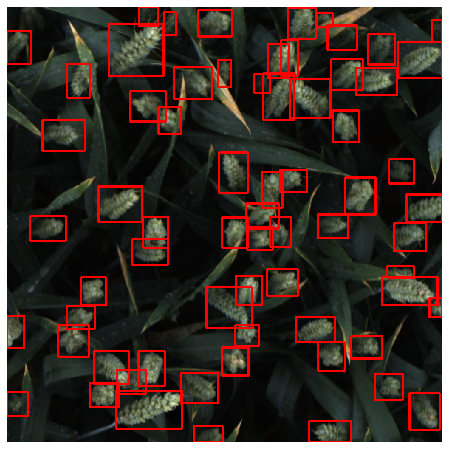

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [29]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

# **References & Credits**

1. TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html